In [125]:

# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import sem

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (12, 8)

print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [126]:
# データ収集関数
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_data_for_bug_detection(logs_root='Logs'):
    """
    バグ発見の有無（二値分類）用のデータを収集
    各行（各実行）ごとに1つのデータポイントを作成し、バグ発見の有無を記録
    ロジスティック回帰分析と同じデータ構造
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            
            if not os.path.exists(detected_bugs_path):
                continue
            
            # detected_bugs.csvの各行を読み込む（各実行ごとにデータポイントを作成）
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                
                for bug_row in bug_reader:
                    # バグ発見の有無を判定
                    bug_detected = 0  # バグ発見の有無（0: なし, 1: あり）
                    
                    if bug_row == ['timeout']:
                        # タイムアウトの場合はバグ発見なしとして扱う
                        bug_detected = 0
                    elif bug_row == ['null']:
                        # 正常終了の場合はバグ発見なし
                        bug_detected = 0
                    else:
                        # バグ発見
                        bug_detected = 1
                    
                    # データポイントを作成
                    data_records.append({
                        'tree': tree_value,
                        'cpNum': cpnum,
                        'cpNum_range': cpnum_range,
                        'cpNum_dir': cpnum_dir,
                        'bug_detected': bug_detected  # バグ発見の有無（二値）
                    })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\nバグ発見の有無の分布:")
    print(df['bug_detected'].value_counts())
    return df

df = collect_data_for_bug_detection(logs_root="../Logs/")

データ収集完了: 10800件のレコード

データの基本統計:
               tree         cpNum   cpNum_range     cpNum_dir  bug_detected
count  10800.000000  10800.000000  10800.000000  10800.000000  10800.000000
mean     500.000000    225.000000     50.000000      1.150000      0.576204
std      408.267192    234.016532     40.010185      0.572303      0.494182
min        0.000000      1.000000      1.000000      1.000000      0.000000
25%        0.000000     50.000000      1.000000      1.000000      0.000000
50%      500.000000    149.500000     50.000000      1.000000      1.000000
75%     1000.000000    300.000000     99.000000      1.000000      1.000000
max     1000.000000    700.000000     99.000000      4.000000      1.000000

バグ発見の有無の分布:
bug_detected
1    6223
0    4577
Name: count, dtype: int64


# タスク0: バグ発見の有無（二値分類）

## モデルの構築・F値計算

In [127]:

# タスク0: バグ発見の有無（二値分類）の予測

# 特徴量と目的変数の準備
X0 = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y0 = df['bug_detected']

# 訓練データとテストデータに分割
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0, y0, test_size=0.2, random_state=42, stratify=y0
)

print(f"訓練データ数: {len(X0_train)}")
print(f"テストデータ数: {len(X0_test)}")
print(f"\n訓練データの目的変数分布:")
print(y0_train.value_counts())
print(f"\nテストデータの目的変数分布:")
print(y0_test.value_counts())

# 標準化（オプション：必要に応じて）
scaler = StandardScaler()
X0_train_scaled = scaler.fit_transform(X0_train)
X0_test_scaled = scaler.transform(X0_test)

# 決定木モデルの訓練と評価（タスク0）
dt_model0 = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=0.05,
    random_state=42
)
dt_model0.fit(X0_train_scaled, y0_train)

# 予測
y0_pred_dt = dt_model0.predict(X0_test_scaled)
y0_pred_proba_dt = dt_model0.predict_proba(X0_test_scaled)[:, 1]

訓練データ数: 8640
テストデータ数: 2160

訓練データの目的変数分布:
bug_detected
1    4978
0    3662
Name: count, dtype: int64

テストデータの目的変数分布:
bug_detected
1    1245
0     915
Name: count, dtype: int64


In [128]:
# モデルの評価

# 評価指標
accuracy = accuracy_score(y0_test, y0_pred_dt)
precision = precision_score(y0_test, y0_pred_dt, zero_division=0)
recall = recall_score(y0_test, y0_pred_dt, zero_division=0)
f1 = f1_score(y0_test, y0_pred_dt, zero_division=0)

# 混同行列
cm = confusion_matrix(y0_test, y0_pred_dt)

print(f"\n【今回のモデル】")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("\n【混同行列】")
print(cm)

# ベースラインモデルの予測を作成
y_pred_always_bug = np.ones(len(y0_test))

# ベースラインモデルの評価
baseline_accuracy = accuracy_score(y0_test, y_pred_always_bug)
baseline_precision = precision_score(y0_test, y_pred_always_bug, zero_division=0)
baseline_recall = recall_score(y0_test, y_pred_always_bug, zero_division=0)
baseline_f1 = f1_score(y0_test, y_pred_always_bug, zero_division=0)

print(f"\n【ベースラインモデル】")
print(f"Accuracy:  {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1-Score:  {baseline_f1:.4f}")

# 混同行列
cm = confusion_matrix(y0_test, y_pred_always_bug)
print("\n【混同行列】")
print(cm)


【今回のモデル】
Accuracy:  0.8375
Precision: 0.8807
Recall:    0.8305
F1-Score:  0.8549

【混同行列】
[[ 775  140]
 [ 211 1034]]

【ベースラインモデル】
Accuracy:  0.5764
Precision: 0.5764
Recall:    1.0000
F1-Score:  0.7313

【混同行列】
[[   0  915]
 [   0 1245]]


## 十分割交差検証

In [ ]:

# 交差検証やっていく
# 10分割交差検証の設定（層化サンプリング）
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 標準化を含むPipelineを作成（交差検証で各foldで標準化を適用）
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(max_depth=None, min_samples_leaf=0.05, random_state=42))
])

# 評価指標を定義
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

cv_results = cross_validate(
    pipeline, X0, y0, 
    cv=cv, 
    scoring=scoring,
    return_train_score=False,
    return_estimator=False,
    n_jobs=-1
)

In [130]:
# 結果の出力
# 10分割交差検証を実行
print("="*70)
print("【バグ発見の有無】sklearnのLogisticRegressionによる10分割交差検証")
print("="*70)

# 全体の統計を計算
mean_accuracy = cv_results['test_accuracy'].mean()
std_accuracy = cv_results['test_accuracy'].std()
mean_precision = cv_results['test_precision'].mean()
std_precision = cv_results['test_precision'].std()
mean_recall = cv_results['test_recall'].mean()
std_recall = cv_results['test_recall'].std()
mean_f1 = cv_results['test_f1'].mean()
std_f1 = cv_results['test_f1'].std()

print("\n【全体の統計（10分割交差検証）】")
print("-"*70)
print(f"Accuracy (正解率):")
print(f"  平均: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"  範囲: [{cv_results['test_accuracy'].min():.4f}, {cv_results['test_accuracy'].max():.4f}]")

print(f"\nPrecision (適合率):")
print(f"  平均: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"  範囲: [{cv_results['test_precision'].min():.4f}, {cv_results['test_precision'].max():.4f}]")

print(f"\nRecall (再現率):")
print(f"  平均: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"  範囲: [{cv_results['test_recall'].min():.4f}, {cv_results['test_recall'].max():.4f}]")

print(f"\nF1 Score (F値):")
print(f"  平均: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"  範囲: [{cv_results['test_f1'].min():.4f}, {cv_results['test_f1'].max():.4f}]")

# 各フォールドの詳細結果
n_folds = len(cv_results['test_accuracy'])
print("\n【各フォールドの詳細結果】")
print("-"*70)
print(f"{'Fold':<6} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
print("-"*70)
for i in range(n_folds):
    print(f"{i+1:<6} {cv_results['test_accuracy'][i]:<12.4f} {cv_results['test_precision'][i]:<12.4f} {cv_results['test_recall'][i]:<12.4f} {cv_results['test_f1'][i]:<12.4f}")



【バグ発見の有無】sklearnのLogisticRegressionによる10分割交差検証

【全体の統計（10分割交差検証）】
----------------------------------------------------------------------
Accuracy (正解率):
  平均: 0.8451 ± 0.0162
  範囲: [0.8167, 0.8787]

Precision (適合率):
  平均: 0.8793 ± 0.0158
  範囲: [0.8430, 0.9085]

Recall (再現率):
  平均: 0.8477 ± 0.0160
  範囲: [0.8266, 0.8778]

F1 Score (F値):
  平均: 0.8631 ± 0.0142
  範囲: [0.8403, 0.8929]

【各フォールドの詳細結果】
----------------------------------------------------------------------
Fold   Accuracy     Precision    Recall       F1 Score    
----------------------------------------------------------------------
1      0.8315       0.8744       0.8266       0.8498      
2      0.8417       0.8767       0.8443       0.8602      
3      0.8352       0.8778       0.8299       0.8531      
4      0.8787       0.9085       0.8778       0.8929      
5      0.8556       0.8820       0.8650       0.8734      
6      0.8602       0.8932       0.8601       0.8763      
7      0.8167       0.8430       0.8376       0.

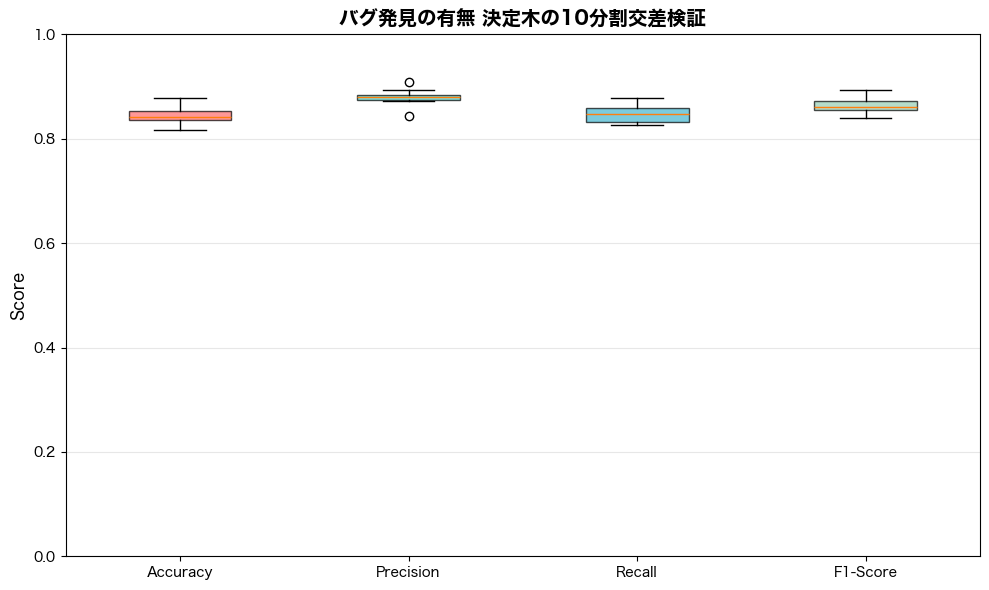

In [131]:
# 交差検証の結果をグラフで表示
# 評価指標のリスト
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# 各評価指標のスコアを取得
test_scores = {
    'accuracy': cv_results['test_accuracy'],
    'precision': cv_results['test_precision'],
    'recall': cv_results['test_recall'],
    'f1': cv_results['test_f1']
}

# 可視化: 箱ひげ図
_, ax = plt.subplots(figsize=(10, 6))

# テストスコアの箱ひげ図
test_data = [test_scores[m] for m in metrics]
bp = ax.boxplot(test_data, tick_labels=metric_labels, patch_artist=True)
# 箱の色を設定
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_title('バグ発見の有無 決定木の10分割交差検証', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()